In [2]:
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
import torchvision.transforms
import os
import time
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
import SimpleITK as sitk
import pandas as pd
import sklearn.model_selection as model_selection
from tqdm import tqdm
import skimage
import pickle
import sys

from unet import UNet,Hybrid_Unet,TorchDataset,flip_scale_crop_test,flip_scale_crop_train
from utils import mean_dice_loss,to_var,to_numpy,save_checkpoint,evalAllmetric
from utils import train_model,validate_model,predict

import pandas as pd


In [40]:
def to_var(x, device):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    x = x.to(device,dtype=torch.float)
    return x
def pre_normalize(img):
    # normalize one modality (3d)
    idx = np.where(img > 0)
    non_zero = img[idx[0], idx[1], idx[2]]
    img_m = np.mean(non_zero)
    img_std = np.std(non_zero)
    if img_std>0:
        img_new = (img - img_m) / img_std
    else:
        img_new = img - img_m
    return img_new

def flip_scale_crop_test(sample):
    irm, mask = sample
    irm_out = []
    mask_out = []
    n_modality = irm.shape[0]
    n_maskc = mask.shape[0]
    # scale
    factor = 0.6
    for k in range(n_modality):
        irm_out.append(skimage.transform.rescale(irm[k], factor,multichannel = False))
    for k in range(n_maskc):
        mask_out.append(np.round(skimage.transform.rescale(mask[k].astype(float), factor,multichannel = False)))
    irm_out = np.stack(irm_out, axis=0)
    mask_out = np.stack(mask_out, axis=0)
    # crop image
    _, a, b, c = irm_out.shape
    irm_ = irm_out[:, (-40 + a // 2):(40 + a // 2), (-64 + b // 2):(64 + b // 2), (-64 + c // 2):(64 + c // 2)]
    mask_ = mask_out[:, (-40 + a // 2):(40 + a // 2), (-64 + b // 2):(64 + b // 2), (-64 + c // 2):(64 + c // 2)]

    return (irm_, mask_)

In [4]:
# choose one sample and present the output of all models 
model_name = 'model.10.pth.tar'
input_path = 'save/baseline_models/3D_unet_concat_new_10/'
middle_path = 'save/fusion_models/3D_unet_middle_fusion_new_10/'
m0_path = 'save/fusion_models/3D_unet_vote_fusion_mod_new_0_epoch_10/'
m1_path = 'save/fusion_models/3D_unet_vote_fusion_mod_new_1_epoch_10/'
m2_path = 'save/fusion_models/3D_unet_vote_fusion_mod_new_2_epoch_10/'
m3_path = 'save/fusion_models/3D_unet_vote_fusion_mod_new_3_epoch_10/'

In [66]:
patient_path = '../Task01_BrainTumour/imagesTr/BRATS_399.nii.gz'
mask_path = '../Task01_BrainTumour/labelsTr/BRATS_399.nii.gz'
irm_ = sitk.GetArrayFromImage(sitk.ReadImage(patient_path))
for i in range(4):
    irm_[i] = pre_normalize(irm_[i])
ref_mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
ref_mask = np.expand_dims(ref_mask,0)

In [67]:
irm,mask = flip_scale_crop_test((irm_,ref_mask))

In [68]:
irm = np.expand_dims(irm,0)

In [69]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
irm_device = to_var(irm.astype(float), device)

In [70]:
input_model = UNet(4,4)
input_model.to(device)
state_dict = torch.load(input_path + model_name)['state_dict']
input_model.load_state_dict(state_dict)

torch.cuda.empty_cache()
with torch.no_grad():
    input_model.eval()
    input_mask = to_numpy(input_model(irm_device))

In [71]:
middle_model = Hybrid_Unet(4,4,[16,32,64,128,128],[256, 128, 64,64])
middle_model.to(device)
state_dict = torch.load(middle_path + model_name)['state_dict']
middle_model.load_state_dict(state_dict)

torch.cuda.empty_cache()
with torch.no_grad():
    middle_model.eval()
    middle_mask = to_numpy(middle_model(irm_device))

In [72]:
m0_model = UNet(1,4)
m0_model.to(device)
state_dict = torch.load(m0_path + model_name)['state_dict']
m0_model.load_state_dict(state_dict)
irm_m0 = torch.unsqueeze(irm_device[:,0,:,:,:],1)
torch.cuda.empty_cache()
with torch.no_grad():
    m0_model.eval()
    m0_mask = to_numpy(m0_model(irm_m0))

In [73]:
m1_model = UNet(1,4)
m1_model.to(device)
state_dict = torch.load(m1_path + model_name)['state_dict']
m1_model.load_state_dict(state_dict)
irm_m1 = torch.unsqueeze(irm_device[:,1,:,:,:],1)
torch.cuda.empty_cache()
with torch.no_grad():
    m1_model.eval()
    m1_mask = to_numpy(m1_model(irm_m1))

In [74]:
m2_model = UNet(1,4)
m2_model.to(device)
state_dict = torch.load(m2_path + model_name)['state_dict']
m2_model.load_state_dict(state_dict)
irm_m2 = torch.unsqueeze(irm_device[:,2,:,:,:],1)
torch.cuda.empty_cache()
with torch.no_grad():
    m2_model.eval()
    m2_mask = to_numpy(m2_model(irm_m2))

In [75]:
m3_model = UNet(1,4)
m3_model.to(device)
state_dict = torch.load(m3_path + model_name)['state_dict']
m3_model.load_state_dict(state_dict)
irm_m3 = torch.unsqueeze(irm_device[:,3,:,:,:],1)
torch.cuda.empty_cache()
with torch.no_grad():
    m3_model.eval()
    m3_mask = to_numpy(m3_model(irm_m3))

In [76]:
imask = np.argmax(input_mask[0],axis=0)
mmask = np.argmax(middle_mask[0],axis=0)
m0mask = np.argmax(m0_mask[0],axis=0)
m1mask = np.argmax(m1_mask[0],axis=0)
m2mask = np.argmax(m2_mask[0],axis=0)
m3mask = np.argmax(m3_mask[0],axis=0)

In [77]:
output_mask = m0_mask + m1_mask + m2_mask + m3_mask 
omask = np.argmax(output_mask[0],axis=0)

In [78]:
mask.shape

(1, 80, 128, 128)

(-0.5, 127.5, 127.5, -0.5)

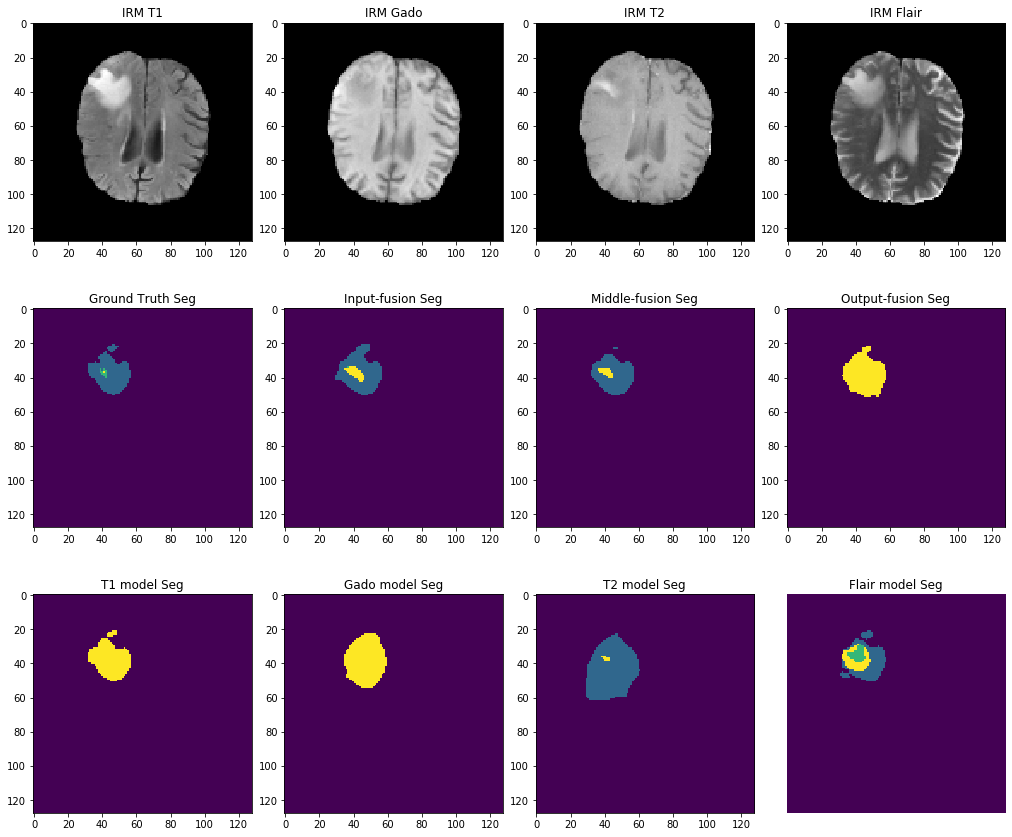

In [85]:
z = 50
fig, ax = plt.subplots(3, 4, figsize=(15, 15),
                           gridspec_kw={'wspace': 0.15, 'hspace': 0.2,
                                              'top': 0.85, 'bottom': 0.1,
                                              'left': 0.05, 'right': 0.95})
ax[0,0].imshow(irm[0,0,z,:,:],cmap='gray')
ax[0,1].imshow(irm[0,1,z,:,:],cmap='gray')
ax[0,2].imshow(irm[0,2,z,:,:],cmap='gray')
ax[0,3].imshow(irm[0,3,z,:,:],cmap='gray')
ax[1,0].imshow(mask[0,z,:,:])
ax[1,1].imshow(imask[z,:,:])
ax[1,2].imshow(mmask[z,:,:])
ax[1,3].imshow(omask[z,:,:])
ax[2,0].imshow(m0mask[z,:,:])
ax[2,1].imshow(m1mask[z,:,:])
ax[2,2].imshow(m2mask[z,:,:])
ax[2,3].imshow(m3mask[z,:,:])

ax[0, 0].set_title('IRM T1') 
ax[0, 1].set_title('IRM Gado')
ax[0, 2].set_title('IRM T2')
ax[0, 3].set_title('IRM Flair')

ax[1, 0].set_title('Ground Truth Seg')
ax[1, 1].set_title('Input-fusion Seg')
ax[1, 2].set_title('Middle-fusion Seg')
ax[1, 3].set_title('Output-fusion Seg')
ax[2, 0].set_title('T1 model Seg')
ax[2, 1].set_title('Gado model Seg')
ax[2, 2].set_title('T2 model Seg')
ax[2, 3].set_title('Flair model Seg')


plt.axis('off')